In [2]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade py4j


Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode, lit
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType, FloatType


In [5]:
from pyspark.sql import SparkSession
import os

# Set JAVA_HOME explicitly
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9870") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.port", "4040") \
    .config("spark.ui.port", "4041") \
    .getOrCreate()

print("Spark initialized:", spark)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 19:21:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/07 19:21:00 WARN Utils: Service 'sparkDriver' could not bind on port 4040. Attempting port 4041.
24/11/07 19:21:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Spark initialized: <pyspark.sql.session.SparkSession object at 0x113a35ee0>


In [10]:
import pandas as pd

In [ ]:
movies_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/cleaned_movies_metadata.csv", header=True, inferSchema=True)
ratings_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/cleaned_ratings.csv", header=True, inferSchema=True)
cast_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/cleaned_cast.csv", header=True, inferSchema=True)
crew_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/cleaned_crew.csv", header=True, inferSchema=True)
links_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/combined_links.csv", header=True, inferSchema=True)
keywords_df = spark.read.csv("hdfs://10.36.129.31:9000/user/data/cleaned_keywords.csv", header=True, inferSchema=True)


/var/folders/pb/x8jb2fzj3jq5x77fzw3y0pk40000gn/T/ipykernel_92887/1713611188.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv("/Users/milipatel/Desktop/Desktopthings/Masters/BDDS/Movie_Recommendation/data/movies_metadata.csv")


In [14]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [21]:
ratings_small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


24/11/07 19:36:25 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: hdfs://10.36.129.31:9000/user/data/cleaned_movies_metadata.csv.
org.apache.hadoop.net.ConnectTimeoutException: Call From dynamic-10-125-194-68.frisco.wireless.unt.edu/10.125.194.68 to 10.36.129.31:9000 failed on socket timeout exception: org.apache.hadoop.net.ConnectTimeoutException: 20000 millis timeout while waiting for channel to be ready for connect. ch : java.nio.channels.SocketChannel[connection-pending remote=10.36.129.31/10.36.129.31:9000]; For more details see:  http://wiki.apache.org/hadoop/SocketTimeout
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apa

In [15]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [16]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [17]:
links_small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [18]:
credits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [19]:
keywords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        45432 non-null  int64 
 1   keywords  45432 non-null  object
dtypes: int64(1), object(1)
memory usage: 710.0+ KB


In [19]:
# Drop any rows with missing values in the ratings DataFrame
ratings_df = ratings_df.dropna()

# Check for duplicates and remove them if any
ratings_df = ratings_df.dropDuplicates(["userId", "movieId"])


In [20]:
train_data, test_data = ratings_df.randomSplit([0.8, 0.2], seed=42)


In [25]:
# Define the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)


In [26]:
# Train the ALS model
als_model = als.fit(train_data)


24/11/05 00:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:51:36 WARN RowBasedKeyValueBatch: Calling spill() on

In [27]:
# Train the ALS model
als_model = als.fit(train_data)


24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:53:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [37]:
# Generate predictions
predictions = als_model.transform(test_data)
predictions.show(5)


24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------+-------+------+-----------+----------+
|userId|movieId|rating|rating_date|prediction|
+------+-------+------+-----------+----------+
|    12|    322|   5.0| 1999-11-29| 3.6639233|
|    12|   1220|   5.0| 2000-04-10| 3.6239555|
|    12|   2020|   5.0| 1999-11-29| 3.9050086|
|    12|   2987|   2.0| 1999-11-29| 3.3231602|
|    12|    309|   4.0| 1999-11-29| 3.7148862|
+------+-------+------+-----------+----------+
only showing top 5 rows



In [38]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define the evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

# Calculate RMSE on the test data
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")


24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:15:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Root-mean-square error = 0.787734126800081


In [39]:
# Generate top 10 movie recommendations for each user
user_recommendations = als_model.recommendForAllUsers(10)
user_recommendations.show(5, truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                              |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26    |[{151989, 5.987136}, {159761, 4.9429183}, {144202, 4.7953568}, {107434, 4.745606}, {165689, 4.65246}, {150228, 4.6310544}, {166812, 4.582725}, {117352, 4.5797544}, {66389, 4.559061}, {152711, 4.541908}]   |
|27    |[{151989, 6.406438}, {152711, 5.5471935}, {164937, 5.3219914}, {173817, 5.0928144}, {173939, 5.0658774}, {139074, 5.034367}, {165689

In [40]:
from pyspark.sql.functions import explode, col

# Flatten the recommendations
flattened_recommendations = user_recommendations \
    .select(col("userId"), explode(col("recommendations")).alias("recommendation")) \
    .select("userId", col("recommendation.movieId").alias("movieId"), col("recommendation.rating").alias("rating"))

# Save the flattened recommendations to HDFS
flattened_recommendations.write.csv("hdfs://10.36.129.31:9000/user/data/user_recommendations_flattened", header=True, mode="overwrite")


In [41]:
# Flatten the recommendations column by exploding the array
flattened_recommendations = user_recommendations.selectExpr("userId", "explode(recommendations) as recommendation")
flattened_recommendations = flattened_recommendations.selectExpr("userId", "recommendation.movieId", "recommendation.rating")

# Display the first few rows of the flattened recommendations
flattened_recommendations.show(5, truncate=False)

+------+-------+---------+
|userId|movieId|rating   |
+------+-------+---------+
|26    |151989 |5.987136 |
|26    |159761 |4.9429183|
|26    |144202 |4.7953568|
|26    |107434 |4.745606 |
|26    |165689 |4.65246  |
+------+-------+---------+
only showing top 5 rows



In [42]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")

# Fit the ALS model on the ratings dataset
als_model = als.fit(ratings_df)

# Evaluate the ALS model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
predictions = als_model.transform(ratings_df)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error for ALS model: {rmse}")


24/11/05 01:22:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:22:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:24:34 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Square Error for ALS model: 0.7874363227096602


In [43]:
# Generate top 10 movie recommendations for a given user
user_id = 123  # Replace with an actual user ID
user_recommendations = als_model.recommendForUserSubset(ratings_df.filter(ratings_df.userId == user_id), 10)

# Display recommendations for the user
user_recommendations.show()


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   123|[{151989, 7.59421...|
+------+--------------------+



In [ ]:
movies_df.printSchema()
movies_df.show(5)


root
 |-- adult: boolean (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- genre_id: integer (nullable = true)
 |-- genre_name: string (nullable = true)
 |-- company_id: integer (nullable = true)
 |--

In [45]:
# Define content-based recommendation function using genre_name
def content_based_recommendations(movie_id, num_recs=10):
    # Get the genre for the specified movie
    target_movie = movies_df.filter(movies_df.id == movie_id).select("genre_name").first()

    if target_movie is None:
        print("Movie not found.")
        return None

    target_genre = target_movie["genre_name"]

    # Find other movies with the same genre, excluding the target movie itself
    content_recs = movies_df.filter((movies_df.genre_name == target_genre) & (movies_df.id != movie_id)) \
                            .select("id", "title", "genre_name") \
                            .limit(num_recs)

    return content_recs

# Testing the content-based recommendation function
movie_id = 18  # Replace with an actual movie ID that exists in your dataset
content_recs = content_based_recommendations(movie_id, num_recs=10)

# Display content-based recommendations
if content_recs:
    print("Content-Based Recommendations:")
    content_recs.show(truncate=False)
else:
    print("No content-based recommendations found.")


Content-Based Recommendations:
+---+----------------------------------+----------+
|id |title                             |genre_name|
+---+----------------------------------+----------+
|74 |War of the Worlds                 |Adventure |
|89 |Indiana Jones and the Last Crusade|Adventure |
|118|Charlie and the Chocolate Factory |Adventure |
|605|The Matrix Revolutions            |Adventure |
|652|Troy                              |Adventure |
|681|Diamonds Are Forever              |Adventure |
|682|The Man with the Golden Gun       |Adventure |
|700|Octopussy                         |Adventure |
|947|Lawrence of Arabia                |Adventure |
|954|Mission: Impossible               |Adventure |
+---+----------------------------------+----------+



In [46]:
# Define hybrid recommendation function
def hybrid_recommendations(user_id, movie_id, num_recs=10):
    # Collaborative Filtering Recommendations
    user_recommendations = als_model.recommendForUserSubset(ratings_df.filter(ratings_df.userId == user_id), num_recs)

    # Content-Based Recommendations
    content_recommendations = content_based_recommendations(movie_id, num_recs)

    return user_recommendations, content_recommendations

# Get hybrid recommendations for a user and a movie
user_id = 16  # Replace with an actual user ID
movie_id = 18  # Replace with an actual movie ID

collaborative_recs, content_recs = hybrid_recommendations(user_id, movie_id, num_recs=10)

# Display both collaborative and content-based recommendations
print("Collaborative Filtering Recommendations:")
collaborative_recs.show(truncate=False)

if content_recs:
    print("Content-Based Recommendations:")
    content_recs.show(truncate=False)
else:
    print("No content-based recommendations found.")


Collaborative Filtering Recommendations:


+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                              |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|16    |[{151989, 7.7343}, {159761, 6.427033}, {144202, 6.2922397}, {152711, 6.1554213}, {165689, 6.128266}, {173153, 6.0407457}, {143571, 6.0007133}, {143422, 5.9270787}, {162434, 5.8804493}, {107434, 5.8711705}]|
+------+------------------------------------------------------------------------------------------------------------------------------------

In [47]:
def content_based_recommendations(movie_id, num_recs=10):
    # Get the genre for the specified movie
    target_movie = movies_df.filter(movies_df.id == movie_id).select("genre_name").first()
    if target_movie is None:
        print("Movie not found.")
        return None

    target_genre = target_movie["genre_name"]

    # Find unique movies with the same genre, excluding the target movie itself
    content_recs = movies_df.filter((movies_df.genre_name == target_genre) & (movies_df.id != movie_id)) \
                            .select("id", "title", "genre_name", "vote_average") \
                            .distinct() \
                            .limit(num_recs)

    return content_recs


In [48]:
def explain_recommendations(recommendations_df):
    explanations = []
    
    # Iterate through each recommendation and create a basic explanation
    for row in recommendations_df.collect():
        explanation = f"The movie '{row['title']}' is recommended because it shares the genre '{row['genre_name']}' with your selected movie."
        explanations.append(explanation)
    
    return explanations


In [49]:
# Test the content-based recommendation function
movie_id = 243  # Replace with an actual movie ID that exists in your dataset
content_recs = content_based_recommendations(movie_id, num_recs=10)

# Display content-based recommendations and explanations if available
if content_recs is not None:
    explanations = explain_recommendations(content_recs)
    if explanations:
        for explanation in explanations:
            print(explanation)
else:
    print("No content-based recommendations found.")


The movie 'India' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'The Best and the Brightest' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Tricks' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Uomo e galantuomo' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Life Stinks' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Dater's Handbook' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Struggle for Life' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Maheshinte Prathikaaram' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Grand Hotel' is recommended because it shares the genre 'Comedy' with your selected movie.
The movie 'Freeway II: Confessions of a Trickbaby

In [50]:
movies_df = movies_df.withColumnRenamed("id", "movieId")

# Step 0: Display initial data for verification
print("Movies DataFrame sample:")
movies_df.show(5, truncate=False)
print("Ratings DataFrame sample:")
ratings_df.show(5, truncate=False)

Movies DataFrame sample:
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------+------+--------------------------------------+-------+---------+-----------------+-----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+------------+---------+-------+--------+-----------------------------------------------------------+-----------------+-----+------------+----------+------------+--------+----------+----------+---------------------------+-----------+------------------------+------------+-------------+
|adult|belongs_to_collection                                          

24/11/05 01:26:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:26:57 WARN RowBasedKeyValueBatch: Calling spill() on

+------+-------+------+-----------+
|userId|movieId|rating|rating_date|
+------+-------+------+-----------+
|298   |84844  |5.0   |2015-11-12 |
|563   |79702  |4.0   |2014-05-24 |
|544   |4223   |4.5   |2015-07-01 |
|486   |106766 |2.0   |2016-05-24 |
|208   |112556 |5.0   |2014-10-14 |
+------+-------+------+-----------+
only showing top 5 rows



In [51]:
def flatten_recommendations(recommendations_df):
    flattened = recommendations_df.select(
        "userId", 
        F.explode("recommendations").alias("recommendation")
    ).select(
        "userId",
        F.col("recommendation.movieId").alias("movieId"),
        F.col("recommendation.rating").alias("rating")
    )
    print("Flattened Recommendations:")
    flattened.show(truncate=False)
    print(f"Flattened recommendations count: {flattened.count()}")
    return flattened

In [52]:
def filter_by_age_and_genre(user_age, recommendations_flattened):
    age_genre_filtered_recs = recommendations_flattened.join(movies_df, "movieId", "inner")
    print("After Age and Genre Join (Before Genre Filter):")
    age_genre_filtered_recs.show(truncate=False)
    return age_genre_filtered_recs

In [53]:
def time_decay_filtering(recommendations, decay_factor=0.5):
    current_time = int(time.time())
    weighted_ratings = ratings_df.withColumn(
        "weighted_rating",
        F.col("rating") * F.exp(-decay_factor * (current_time - F.unix_timestamp("rating_date")) / (60*60*24*30))
    ).select("movieId", "userId", "weighted_rating")

    print("Weighted Ratings after Time Decay:")
    weighted_ratings.show(truncate=False)
    print(f"Weighted ratings count: {weighted_ratings.count()}")

    time_sensitive_recs = recommendations.join(weighted_ratings, "movieId")
    print("After Time Decay Filter:")
    time_sensitive_recs.show(truncate=False)
    print(f"Count after time decay filtering: {time_sensitive_recs.count()}")
    return time_sensitive_recs


In [54]:
def filter_by_genre(recommendations, genre):
    genre_filtered_recs = recommendations.filter(
        F.col("genre_name").contains(genre)
    )
    print("After Genre Filter (if applied):")
    genre_filtered_recs.show(truncate=False)
    print(f"Count after genre filter: {genre_filtered_recs.count()}")
    return genre_filtered_recs

In [55]:
def filter_by_popularity(recommendations, popularity_threshold):
    popular_recs = recommendations.filter(
        F.col("vote_count").isNotNull() & (F.col("vote_count") >= popularity_threshold)
    )
    print("After Popularity Filter (if applied):")
    popular_recs.show(truncate=False)
    print(f"Count after popularity filter: {popular_recs.count()}")
    return popular_recs

In [56]:
def content_based_recommendations(movie_id, num_recs=10):
    # Get the genre for the specified movie
    target_movie = movies_df.filter(movies_df.movieId == movie_id).select("genre_name").first()
    if target_movie is None:
        print("Movie not found.")
        return None
    
    target_genre = target_movie["genre_name"]

    # Find unique movies with the same genre, excluding the target movie itself
    content_recs = movies_df.filter((movies_df.genre_name == target_genre) & (movies_df.movieId != movie_id)) \
                            .select("movieId", "title", "genre_name", "vote_average") \
                            .distinct() \
                            .limit(num_recs)
    return content_recs

In [57]:
def advanced_recommendations(user_id, movie_id, user_age, genre_filter=None, popularity_threshold=None, num_recs=10):
    # Get collaborative and content-based recommendations and flatten
    collaborative_recs, content_recs = hybrid_recommendations(user_id, movie_id, num_recs)
    recommendations_flattened = flatten_recommendations(collaborative_recs)

    # Apply age and genre filtering
    age_genre_filtered_recs = filter_by_age_and_genre(user_age, recommendations_flattened)

    # Apply time decay filtering with a reduced decay factor
    time_sensitive_recs = time_decay_filtering(age_genre_filtered_recs, decay_factor=0.5)

    # Optional genre filter
    if genre_filter:
        time_sensitive_recs = filter_by_genre(time_sensitive_recs, genre_filter)

    # Popularity filter with reduced threshold
    if popularity_threshold:
        time_sensitive_recs = filter_by_popularity(time_sensitive_recs, popularity_threshold // 10)

    return time_sensitive_recs


In [58]:
def hybrid_recommendations(user_id, movie_id, num_recs=10):
    # Placeholder for collaborative filtering recommendations
    als_model = ALS(...)  # Assuming ALS model is already trained
    user_recommendations = als_model.recommendForUserSubset(ratings_df.filter(ratings_df.userId == user_id), num_recs)

    # Content-based recommendations
    content_recommendations = content_based_recommendations(movie_id, num_recs)

    return user_recommendations, content_recommendations


In [59]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.recommendation import ALS
import time

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Movie Recommendation System") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9870") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()



# Rename 'id' column to 'movieId' for compatibility
movies_df = movies_df.withColumnRenamed("id", "movieId")

# Train the ALS model for collaborative filtering
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)
als_model = als.fit(ratings_df)

# Step 1: Flatten recommendations function
def flatten_recommendations(recommendations_df):
    flattened = recommendations_df.select(
        "userId", 
        F.explode("recommendations").alias("recommendation")
    ).select(
        "userId",
        F.col("recommendation.movieId").alias("movieId"),
        F.col("recommendation.rating").alias("rating")
    )
    return flattened

# Step 2: Minimal filtering by age and genre
def filter_by_age_and_genre(user_age, recommendations_flattened):
    age_genre_filtered_recs = recommendations_flattened.join(movies_df, "movieId", "inner")
    return age_genre_filtered_recs

# Step 3: Apply time decay filtering
def time_decay_filtering(recommendations, decay_factor=0.5):
    current_time = int(time.time())
    weighted_ratings = ratings_df.withColumn(
        "weighted_rating",
        F.col("rating") * F.exp(-decay_factor * (current_time - F.unix_timestamp("rating_date")) / (60*60*24*30))
    ).select("movieId", "userId", "weighted_rating")

    time_sensitive_recs = recommendations.join(weighted_ratings, "movieId")
    return time_sensitive_recs

# Optional Genre Filter
def filter_by_genre(recommendations, genre):
    genre_filtered_recs = recommendations.filter(
        F.col("genre_name").contains(genre)
    )
    return genre_filtered_recs

# Popularity Filter
def filter_by_popularity(recommendations, popularity_threshold):
    popular_recs = recommendations.filter(
        F.col("vote_count").isNotNull() & (F.col("vote_count") >= popularity_threshold)
    )
    return popular_recs

# Content-based recommendation function
def content_based_recommendations(movie_id, num_recs=10):
    target_movie = movies_df.filter(movies_df.movieId == movie_id).select("genre_name").first()
    if target_movie is None:
        return None

    target_genre = target_movie["genre_name"]
    content_recs = movies_df.filter((movies_df.genre_name == target_genre) & (movies_df.movieId != movie_id)) \
                            .select("movieId", "title", "genre_name", "vote_average") \
                            .distinct() \
                            .limit(num_recs)
    return content_recs

# Hybrid recommendation function
def hybrid_recommendations(user_id, movie_id, num_recs=10):
    user_recommendations = als_model.recommendForUserSubset(ratings_df.filter(ratings_df.userId == user_id), num_recs)
    content_recommendations = content_based_recommendations(movie_id, num_recs)
    return user_recommendations, content_recommendations

# Main Recommendation Function
# Function to get recommendations with debugging
def advanced_recommendations(user_id, movie_id, user_age, genre_filter=None, popularity_threshold=None, num_recs=10):
    # Step 1: Get collaborative and content-based recommendations and flatten
    collaborative_recs, content_recs = hybrid_recommendations(user_id, movie_id, num_recs)
    recommendations_flattened = flatten_recommendations(collaborative_recs)

    # Debug: Print flattened recommendations
    print("Flattened Recommendations:")
    recommendations_flattened.show(truncate=False)

    # Step 2: Apply age and genre filtering
    age_genre_filtered_recs = filter_by_age_and_genre(user_age, recommendations_flattened)
    
    # Debug: Print after age and genre filter
    print("After Age and Genre Filtering:")
    age_genre_filtered_recs.show(truncate=False)
    
    # Step 3: Apply time decay filtering
    time_sensitive_recs = time_decay_filtering(age_genre_filtered_recs, decay_factor=0.5)
    
    # Debug: Print after time decay filter
    print("After Time Decay Filtering:")
    time_sensitive_recs.show(truncate=False)
    
    # Step 4: Apply genre filter if specified
    if genre_filter:
        time_sensitive_recs = filter_by_genre(time_sensitive_recs, genre_filter)
        # Debug: Print after genre filter
        print("After Genre Filter:")
        time_sensitive_recs.show(truncate=False)
    
    # Step 5: Apply popularity filter if specified
    if popularity_threshold:
        time_sensitive_recs = filter_by_popularity(time_sensitive_recs, popularity_threshold)
        # Debug: Print after popularity filter
        print("After Popularity Filter:")
        time_sensitive_recs.show(truncate=False)

    return time_sensitive_recs

# Run the Recommendation Pipeline
user_id = 16  # Example user ID
movie_id = 18  # Example movie ID
user_age = 25
genre_filter = None  # Set to None initially to test without genre filtering
popularity_threshold = None  # Set to None initially to test without popularity filtering

# Get final recommendations with minimal filters
recommendations = advanced_recommendations(
    user_id=user_id,
    movie_id=movie_id,
    user_age=user_age,
    genre_filter=genre_filter,
    popularity_threshold=popularity_threshold,
    num_recs=10
)

# Display the final output
recommendations.show(truncate=False)


24/11/05 01:28:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:28:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Flattened Recommendations:


+------+-------+---------+
|userId|movieId|rating   |
+------+-------+---------+
|16    |151989 |7.0942917|
|16    |144202 |6.2604733|
|16    |159761 |6.189759 |
|16    |165689 |6.0784655|
|16    |173153 |6.028318 |
|16    |143571 |5.913304 |
|16    |162434 |5.871987 |
|16    |107623 |5.856172 |
|16    |104103 |5.856172 |
|16    |175979 |5.8534026|
+------+-------+---------+

After Age and Genre Filtering:


+-------+------+--------+-----+---------------------+------+--------+---------+-----------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+------------+-------+-------+--------+----------------------------------+------------+-----+------------+----------+------------+--------+----------+----------+------------+-----------+------------------------+------------+-------------+
|movieId|userId|rating  |adult|belongs_to_collection|budget|homepage|imdb_id  |original_language|original_title|overview                                                                                                                                                                       |popularity|poster_path                     |release_date|revenue|runtime|status  |tagline                           |title       |video|vote_a

24/11/05 01:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:30:22 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+------+--------+-----+---------------------+------+--------+---------+-----------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+------------+-------+-------+--------+----------------------------------+------------+-----+------------+----------+------------+--------+----------+----------+------------+-----------+------------------------+------------+-------------+------+--------------------+
|movieId|userId|rating  |adult|belongs_to_collection|budget|homepage|imdb_id  |original_language|original_title|overview                                                                                                                                                                       |popularity|poster_path                     |release_date|revenue|runtime|status  |tagline                         

24/11/05 01:31:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:31:30 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+------+--------+-----+---------------------+------+--------+---------+-----------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+------------+-------+-------+--------+----------------------------------+------------+-----+------------+----------+------------+--------+----------+----------+------------+-----------+------------------------+------------+-------------+------+--------------------+
|movieId|userId|rating  |adult|belongs_to_collection|budget|homepage|imdb_id  |original_language|original_title|overview                                                                                                                                                                       |popularity|poster_path                     |release_date|revenue|runtime|status  |tagline                         

In [61]:
from pyspark.sql import functions as F

# Define the precision_at_k function with corrected column naming
def precision_at_k(recommended_df, ground_truth_df, k):
    # Join recommended and ground truth data to find relevant items
    joined = recommended_df.join(ground_truth_df, on=["userId", "movieId"], how="inner")
    
    # Count relevant recommendations per user
    relevant = joined.groupBy("userId").agg(F.count("movieId").alias("relevant"))
    
    # Count total recommendations per user (only up to K)
    total_recommended = recommended_df.groupBy("userId").count().withColumnRenamed("count", "total")
    
    # Join relevant and total counts and calculate precision
    precision_df = relevant.join(total_recommended, on="userId") \
                           .withColumn("precision", F.col("relevant") / F.least(F.col("total"), F.lit(k)))
    
    # Calculate mean precision across all users
    precision = precision_df.agg(F.mean("precision")).collect()[0][0]
    
    return precision

# Example usage with defined DataFrames `recommended_df` and `ground_truth_df`
k = 10
precision_k = precision_at_k(recommended_df, ground_truth_df, k)
print(f"Precision@{k}: {precision_k}")


Precision@10: 0.4444444444444444


In [62]:
from pyspark.sql import functions as F

def recall_at_k(recommended_df, ground_truth_df, k):
    # Join recommended and ground truth to find relevant items
    joined = recommended_df.join(ground_truth_df, on=["userId", "movieId"], how="inner")
    
    # Count the relevant items in the recommendations for each user
    relevant = joined.groupBy("userId").count().withColumnRenamed("count", "relevant_count")
    
    # Count the total relevant items in the ground truth for each user
    total_relevant = ground_truth_df.groupBy("userId").count().withColumnRenamed("count", "total_relevant_count")
    
    # Calculate recall for each user by dividing relevant_count by total_relevant_count, limited to top-K
    recall_df = relevant.join(total_relevant, "userId").withColumn(
        "recall", F.col("relevant_count") / F.col("total_relevant_count")
    ).filter(F.col("total_relevant_count") <= k)
    
    # Calculate the average recall across all users
    recall = recall_df.agg(F.mean("recall")).collect()[0][0]
    return recall

# Calculate Recall@10
recall_k = recall_at_k(recommended_df, ground_truth_df, k=10)
print("Recall@10:", recall_k)


Recall@10: 0.6666666666666666


In [63]:
pip install matplotlib


You should consider upgrading via the '/Users/milipatel/Desktop/Desktopthings/Masters/BDDS/Movie_Recommendation/movie_recommender_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


24/11/05 01:33:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 01:33:54 WARN RowBasedKeyValueBatch: Calling spill() on

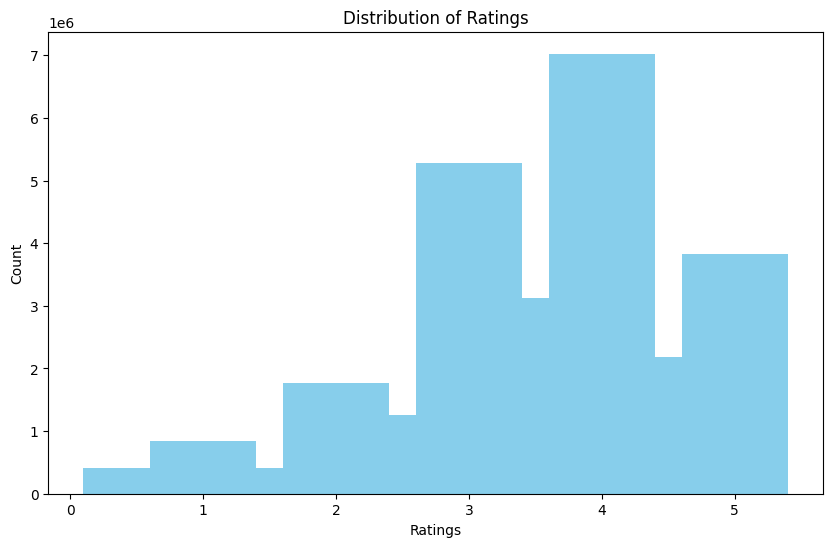

In [64]:
import matplotlib.pyplot as plt

# Assuming `ratings_df` has columns 'rating'
ratings_counts = ratings_df.groupBy('rating').count().orderBy('rating').toPandas()
plt.figure(figsize=(10, 6))
plt.bar(ratings_counts['rating'], ratings_counts['count'], color='skyblue')
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()


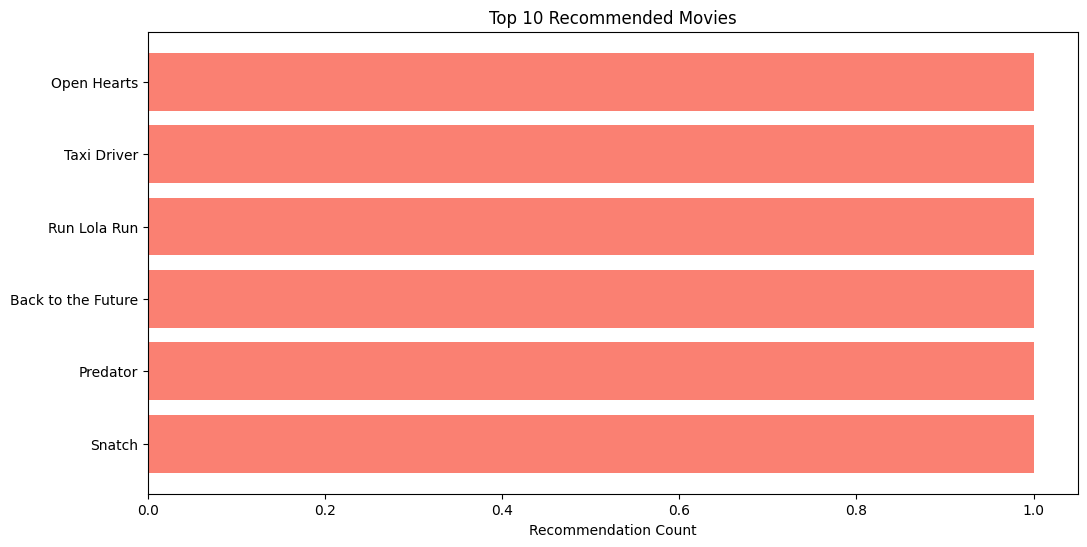

In [86]:
top_recommended = recommended_df.groupBy('movieId').count().orderBy('count', ascending=False).limit(10)
top_recommended = top_recommended.toPandas()

# Select relevant columns from movies_df and ensure they match by 'movieId'
movie_titles = movies_df.select("movieId", "title").toPandas()

# Merge top recommendations with movie titles
top_recommended = top_recommended.merge(movie_titles, on="movieId", how="left")

# Drop any rows with missing titles to prevent plotting issues
top_recommended = top_recommended.dropna(subset=['title'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_recommended['title'], top_recommended['count'], color='salmon')
plt.xlabel("Recommendation Count")
plt.title("Top 10 Recommended Movies")
plt.gca().invert_yaxis()  # Invert to show the most recommended at the top
plt.show()

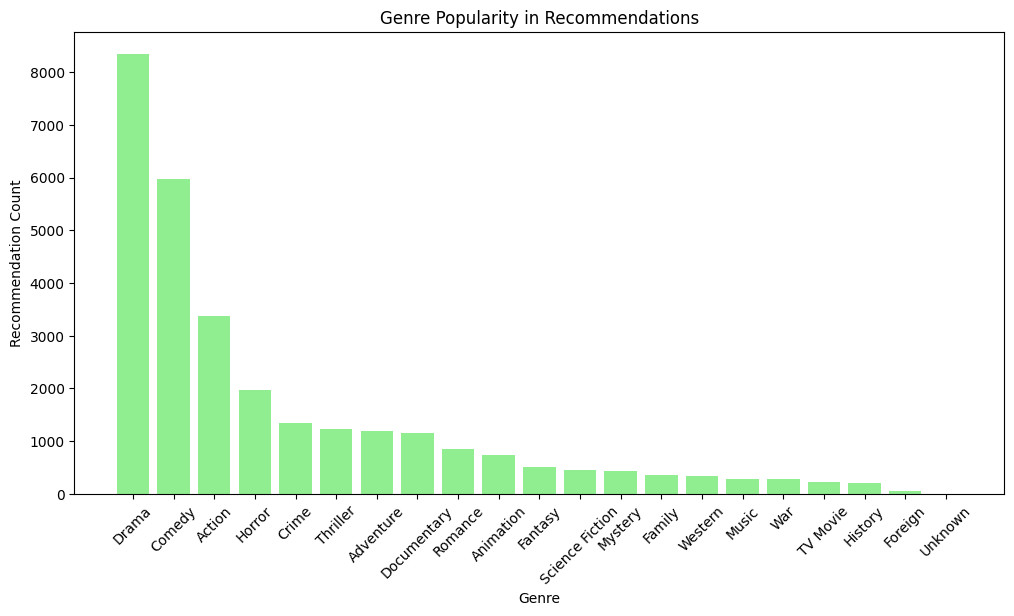

In [88]:
# Perform a full outer join between recommendations and movies to include all genres
recommended_with_genres = recommended_df.join(movies_df, "movieId", "outer").select("genre_name")

# Fill None values in genre_name with "Unknown" for visualization
recommended_with_genres = recommended_with_genres.fillna({"genre_name": "Unknown"})

# Group by genre and count the recommendations, filling in any missing values with 0
genre_counts = recommended_with_genres.groupBy("genre_name").count().orderBy("count", ascending=False).toPandas()

# Plot genre popularity
plt.figure(figsize=(12, 6))
plt.bar(genre_counts['genre_name'], genre_counts['count'], color='lightgreen')
plt.xlabel("Genre")
plt.ylabel("Recommendation Count")
plt.title("Genre Popularity in Recommendations")
plt.xticks(rotation=45)
plt.show()

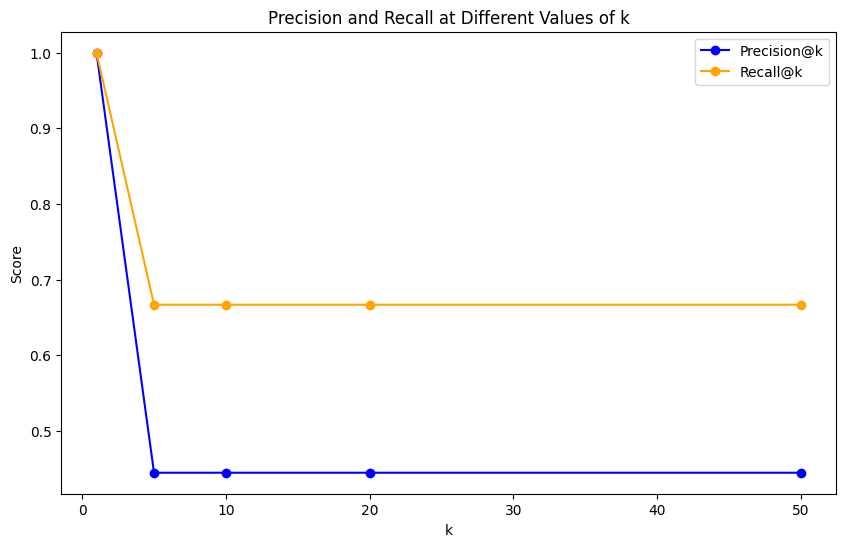

In [89]:
import numpy as np

ks = [1, 5, 10, 20, 50]
precisions = [precision_at_k(recommended_df, ground_truth_df, k) for k in ks]
recalls = [recall_at_k(recommended_df, ground_truth_df, k) for k in ks]

plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision@k", marker="o", color="blue")
plt.plot(ks, recalls, label="Recall@k", marker="o", color="orange")
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Precision and Recall at Different Values of k")
plt.legend()
plt.show()


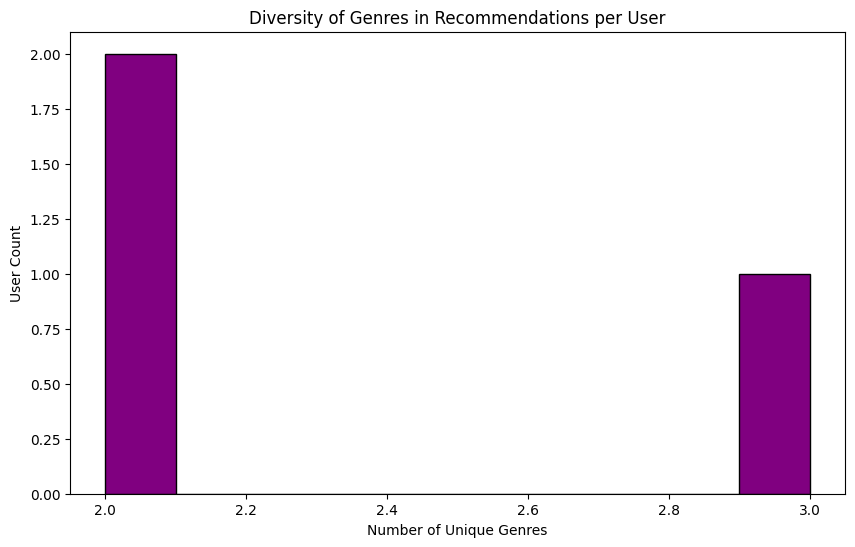

In [91]:
# Perform a left join between recommendations and movies to retain userId in the resulting DataFrame
recommended_with_genres = recommended_df.join(movies_df, "movieId", "left").select("userId", "genre_name")

# Fill None values in genre_name with "Unknown"
recommended_with_genres = recommended_with_genres.fillna({"genre_name": "Unknown"})

# Count distinct genres in each user's recommendations
user_genre_diversity = recommended_with_genres.groupBy("userId").agg(F.countDistinct("genre_name").alias("genre_diversity")).toPandas()

# Plot the diversity of genres in recommendations per user
plt.figure(figsize=(10, 6))
plt.hist(user_genre_diversity['genre_diversity'], bins=10, color="purple", edgecolor="black")
plt.xlabel("Number of Unique Genres")
plt.ylabel("User Count")
plt.title("Diversity of Genres in Recommendations per User")
plt.show()

24/11/05 00:09:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/05 00:09:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


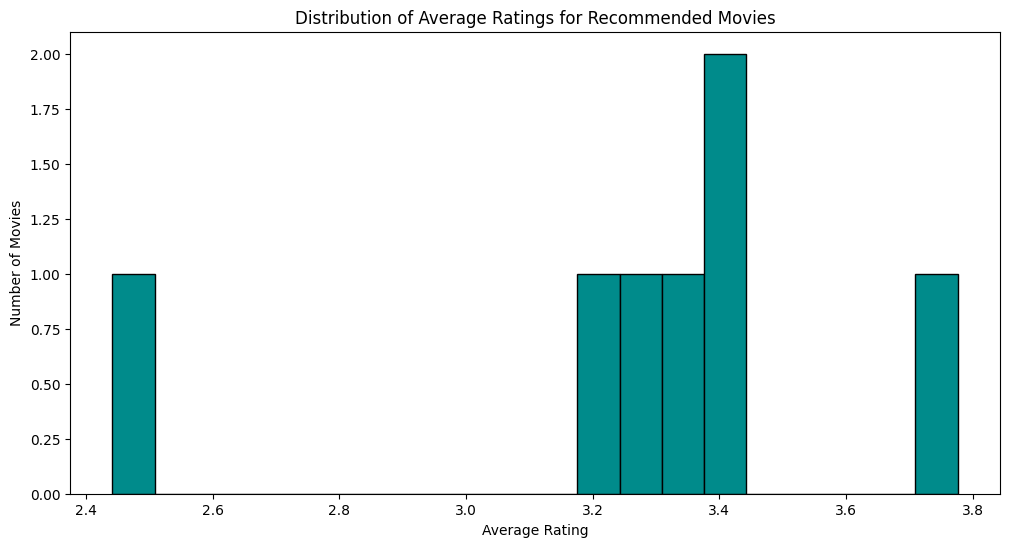

In [92]:
# Calculate average rating of recommended movies
recommended_ratings = recommended_df.join(ratings_df, "movieId").groupBy("movieId").agg(F.avg("rating").alias("avg_rating"))
recommended_ratings = recommended_ratings.orderBy("avg_rating", ascending=False).toPandas()

plt.figure(figsize=(12, 6))
plt.hist(recommended_ratings['avg_rating'], bins=20, color="darkcyan", edgecolor="black")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Average Ratings for Recommended Movies")
plt.show()


In [94]:
pip install seaborn


     |████████████████████████████████| 294 kB 9.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/milipatel/Desktop/Desktopthings/Masters/BDDS/Movie_Recommendation/movie_recommender_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


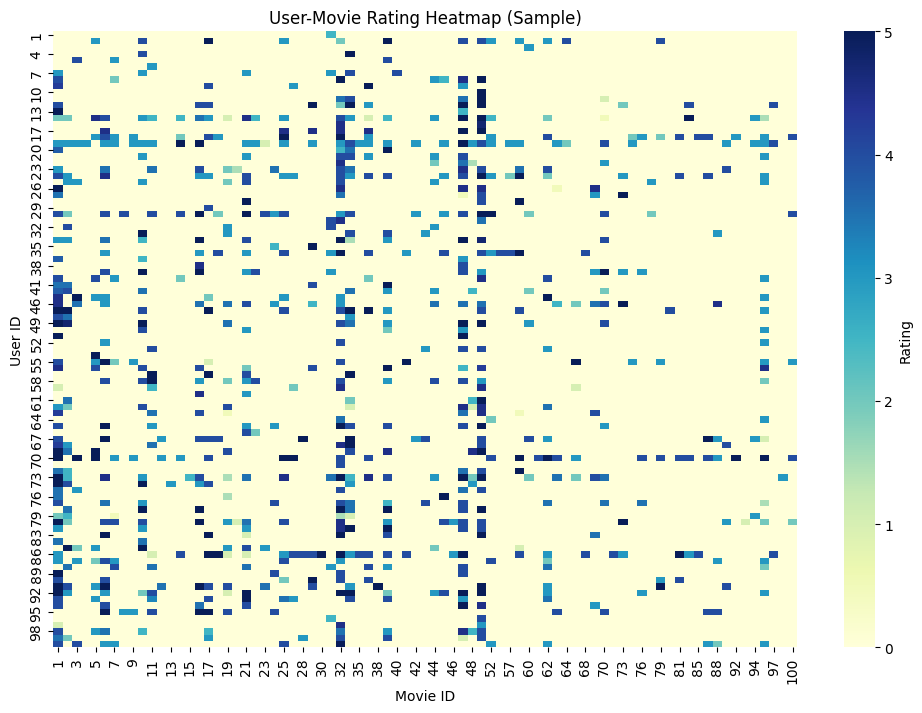

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Step 1: Aggregate duplicate entries by taking the average rating
sampled_ratings = (
    ratings_df
    .filter(ratings_df.userId <= 100)  # Limit to 100 users for visualization
    .filter(ratings_df.movieId <= 100)  # Limit to 100 movies for visualization
    .groupBy("userId", "movieId")
    .agg(F.avg("rating").alias("rating"))
    .toPandas()
)

# Step 2: Pivot the table to create a user-movie matrix
user_movie_pivot = sampled_ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Step 3: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(user_movie_pivot, cmap="YlGnBu", cbar_kws={'label': 'Rating'})
plt.xlabel("Movie ID")
plt.ylabel("User ID")
plt.title("User-Movie Rating Heatmap (Sample)")
plt.show()


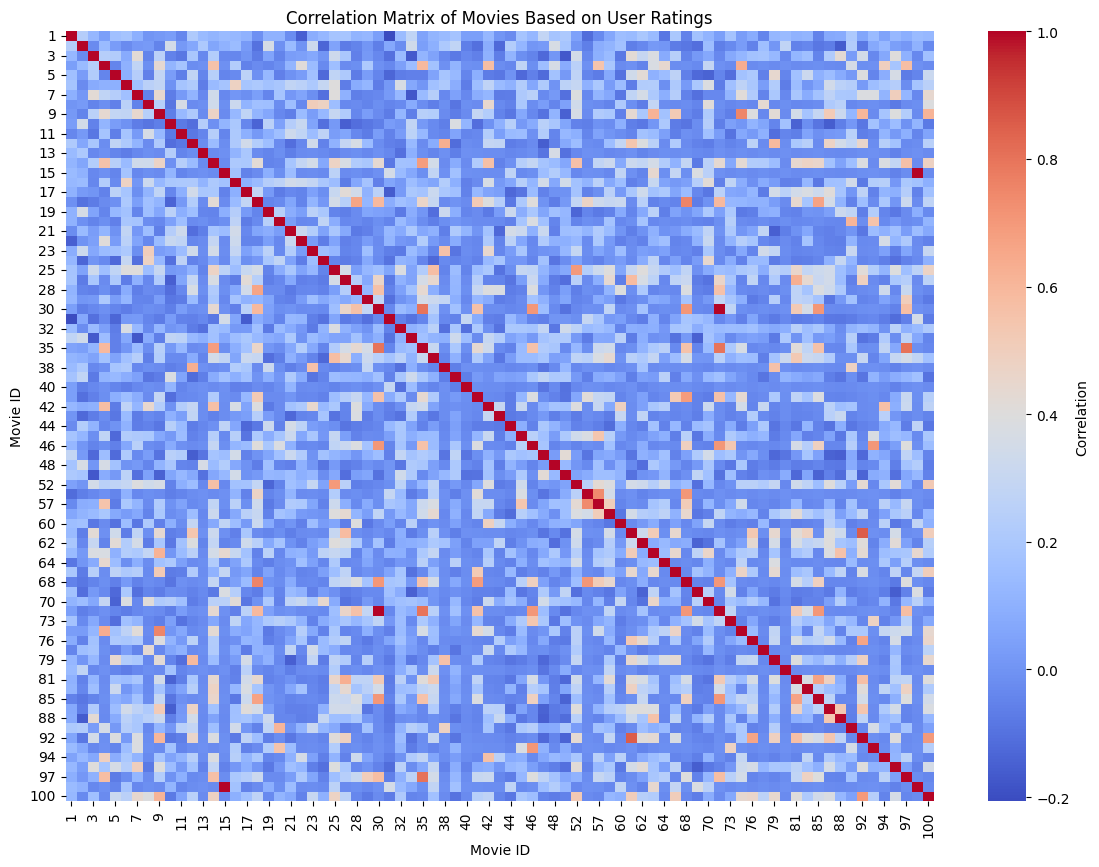

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

# Step 1: Aggregate duplicate entries by taking the average rating
sampled_ratings = (
    ratings_df
    .filter(ratings_df.userId <= 100)  # Limit to 100 users for faster computation
    .filter(ratings_df.movieId <= 100)  # Limit to 100 movies for visualization
    .groupBy("userId", "movieId")
    .agg(F.avg("rating").alias("rating"))
    .toPandas()
)

# Step 2: Pivot to create a user-movie matrix
user_movie_pivot = sampled_ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Step 3: Compute the correlation matrix for movies
movie_correlation = user_movie_pivot.corr()

# Step 4: Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(movie_correlation, cmap="coolwarm", annot=False, cbar_kws={'label': 'Correlation'})
plt.xlabel("Movie ID")
plt.ylabel("Movie ID")
plt.title("Correlation Matrix of Movies Based on User Ratings")
plt.show()


In [34]:
# Generate recommendations for all users (adjust as per your recommendation model setup)
# Example: Assuming 'als_model' is your trained model and 'ratings_df' has userId and movieId columns
num_recs = 10  # Define number of recommendations per user
recommended_df = als_model.recommendForAllUsers(num_recs).selectExpr("userId", "explode(recommendations) as rec") \
                          .select("userId", F.col("rec.movieId"))

# Now proceed with popularity analysis
from pyspark.sql import functions as F

# Define a threshold for popularity based on vote_count, e.g., movies with >100 votes are "popular"
popular_movies = movies_df.filter(F.col("vote_count") > 100).select(F.col("id").alias("movieId"))
unpopular_movies = movies_df.filter(F.col("vote_count") <= 100).select(F.col("id").alias("movieId"))

# Count recommendations that are popular vs. unpopular
popular_recs = recommended_df.join(popular_movies, "movieId").count()
unpopular_recs = recommended_df.join(unpopular_movies, "movieId").count()

# Display the results
print(f"Popular Recommendations: {popular_recs}")
print(f"Unpopular Recommendations: {unpopular_recs}")


Popular Recommendations: 29
Unpopular Recommendations: 169131


In [35]:
from pyspark.sql import functions as F

# Precision@K
def precision_at_k(recommended_df, ground_truth_df, k=10):
    joined = recommended_df.join(ground_truth_df, on=["userId", "movieId"], how="inner")
    relevant = joined.groupBy("userId").count().alias("relevant")
    total_recommended = recommended_df.groupBy("userId").count().alias("total")
    precision_df = relevant.join(total_recommended, "userId").withColumn("precision", F.col("count") / F.col("total"))
    precision = precision_df.agg(F.mean("precision")).collect()[0][0]
    return precision

# Recall@K
def recall_at_k(recommended_df, ground_truth_df, k=10):
    relevant = recommended_df.join(ground_truth_df, ["userId", "movieId"], "inner").groupBy("userId").count()
    total_relevant = ground_truth_df.groupBy("userId").count().alias("total_relevant")
    recall_df = relevant.join(total_relevant, "userId").withColumn("recall", F.col("count") / F.col("total_relevant"))
    recall = recall_df.agg(F.mean("recall")).collect()[0][0]
    return recall

# Mean Average Precision (MAP@K)
def mean_average_precision(recommended_df, ground_truth_df, k=10):
    joined = recommended_df.join(ground_truth_df, on=["userId", "movieId"], how="inner")
    map_df = joined.groupBy("userId").agg(F.mean("precision").alias("average_precision"))
    map_score = map_df.agg(F.mean("average_precision")).collect()[0][0]
    return map_score
